# Chapter 16: Reinforcement Learning
-----
-----

Two important techniques: policy gradients and deep Q-networks. can be uased for a wide variety of tasks.

## Learning to Optimize Rewards
-----

A software `agent` makes `observations` and takes `actions` within an `environment`, and in return it receives `rewards`.

Agent acts in environment and learns by trial and error to maximize its pleasure and minimize its pain.

Note may not be any positive rewards at all.

## Policy Search
-----

The algorithm used by the software agent to determine its actions is called its policy. (could be a nueral net taking observations as input and outputting actions to take)

Policy does not have to be deterministic(stochastic policy).

Policy search: trying out many different values for the algos parameters and picking the combination that preforms the best. (brute force) Note plocy space can be large making it impossible.

Another way a searching policy space is to use genetic algorithms: try 100 different policies, kill 80 of the worst and make the 20 produce 4 offsprings each. (copy of its parent plus a random variation)

Another way is to use optimization techniques, by evaluating the gradients of the rewards with regards to the policy parameters, then tweak these parameters by following the gradient towards higher rewards. (policy gradients)

## Introduction the OpenAI Gym
-----

Challenges of RL is in order to train agent, you first need to have a working environment. training is hard and slow in the real world, so you need simulated environment at least to bootstrap training.

[OpenAI gym](https://gym.openai.com): toolkit that provides a wide variety of simulated environments, so you can train agents, compare them, or develop new RL algorithms.

In [1]:
import gym

env = gym.make("CartPole-v0")
obs = env.reset()
obs

array([-0.01882182, -0.01989054,  0.0231785 ,  0.04475187])

In [2]:
#env.render()

In [3]:
# asking the environment what actions are possible
env.action_space

Discrete(2)

In [4]:
# means action are int 0(move left) and 1(move right)

action = 1 # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.01921963,  0.1748915 ,  0.02407354, -0.24052885])

In [5]:
reward

1.0

In [6]:
done

False

In [7]:
info

{}

Simple policy that accelerates left when pole is leaning towards the left and accelerates right when the pole is leaning toward the right

In [8]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
env = gym.make("CartPole-v0")

for episode in range(500):
    episode_reward = 0
    obs = env.reset()
    for step in range(1000):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            break
    totals.append(episode_reward)

In [9]:
import numpy as np
print("mean= %f\tstd= %f\tmin= %f\tmax= %f" % (np.mean(totals), np.std(totals), np.min(totals), np.max(totals)))

mean= 41.742000	std= 8.792920	min= 24.000000	max= 72.000000


## Neural Network Policies
-----
Create policy, it will estimate a propability for each action, and then we will selection an action randomly according to the estimated probabilities.

One output neuron, probability p of action 0 and probability of action 1 will be 1-p

we use random because lets agent find the right balance between exploring new actions and exploiting the actions that are known to work well

In [10]:
# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf

In [11]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [12]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [13]:
# 1. specify the network arch
n_inputs = 4 # == env.observations_space.shape[0]
n_hidden = 4 # it's a simple task
n_outputs = 1 # only one output
initializer = tf.variance_scaling_initializer()

# 2. build network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid, kernel_initializer=initializer)

# 3. select random action based on estimated prob
p_left_and_right = tf.concat(axis=1, values=[outputs, 1-outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

In [14]:
n_max_steps = 1000
frames = []
env = gym.make("CartPole-v0")
with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

<IPython.core.display.Javascript object>


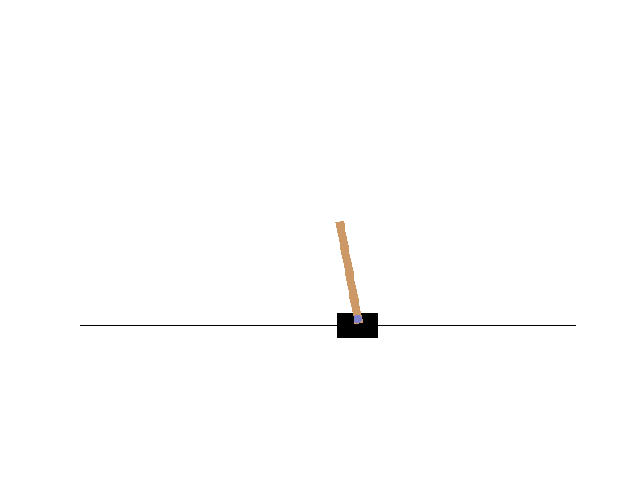

In [15]:
video = plot_animation(frames)
plt.show()

## Evaluating Actions: The Credit Assignment Problem
-----

if we knew the best action was at each step, we could train the neural network as usual, by minimizing the cross entropy between estimated probability and the target prob. But because it RL, only guidance is through the rewards, which are typically sparse and delayed.

Example: say it balances for 100 steps, how does it know which 100 actions are good? All it knows is that the last action caused the poll to fall, but the blame does not belong to just the last action.( credit assignment problem)

credit assignment problem: when an agent get a reward, it is hard to know which action should get credit for it.

Common stategy is to evaluate an action based on the sum of all rewards that come after it, usually applying a discount rate `r` at each step.

Example: agent goes right 3 times, get +10, 0 and -50 respectively, r = 0.8, then the first action will have a score of 10 + r * 0 + r^2 * (-50) = -22


## Policy Gradients
-----

1. Let neural net policy play game several times and at each step compute gradient that would make the chosen action more likely, but don't apply gradients.
2. Once you have several episodes, compute each action's score
3. If an action's score is positive, it means that the action was good and you want to apply the gradients compuated earlier to make the action even more likely to be chosen in the future. If score is negative, action was bad, apply the opposite gradient making action slightly less likely. The solution is to multiply each gradient vector by corresponding action's score.
4. Compute mean of all the resulting gradient vectors and use it to preform a gradient descent step

In [16]:
reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy) # return list of gradient vectors/variable pair
gradients = [grad for grad, variable in grads_and_vars] # putting gradient in list

# during execution phase, the algo will run policy and at each step it will evaluate these gradient tensors and store their values
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [17]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [18]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [19]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [20]:
env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradient_val = sess.run([action, gradients], feed_dict={X:obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradient_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "tmp_models/ch16_my_policy_net_pg.ckpt")

Iteration: 249

In [21]:
env.close()

In [22]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

INFO:tensorflow:Restoring parameters from tmp_models/ch16_my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


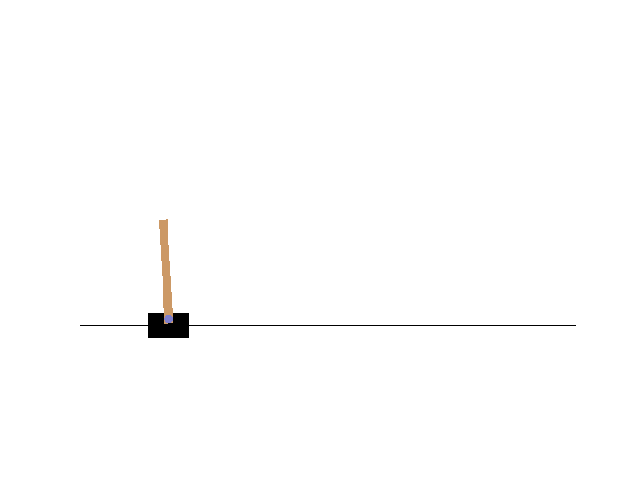

In [23]:
frames = render_policy_net("tmp_models/ch16_my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()

## Markov Decision Processes
-----
Markov chains: stochastic process with no memory. Has fixed number of states, and randomly evolves from one state to another state at each step.

## Temporal Difference Learning and Q-Learning
-----

RL problems with discrete actions can often be modeled as Markov decision process, but the agent initially has no idea what transition probabilities are, and it does not know what the rewards are going too be either.

Temporal Difference Learning algorithm similar to Value Interation algo, but takes into account the fact that the agent only has partial knowledge of MPD.

In [24]:
import numpy.random as rnd

learning_rate = 0.05
learning_rate_decay = 0.1
n_iterations = 20000

s = 0 # startin state 0

Q = np.full((3,3), -np.inf)
for state, action in enumerate(possible_actions):
    Q[state, action] = 0.0 # initial valur for all possible actions
    
for iteration in range(n_iterations):
    a = rnd.choice(possible_actions[s])
    sp = rnd.choice(range=3, p=T[s,a])
    reward = R[s,a,sp]
    learning_rate = learning_rate / (1 + iteration * learning_rate_decay)
    Q[s,a] = learning_rate * Q[s,a] + ( 1 - learning_rate) * reward + discount_rate * np.max(Q[sp])
    s = sp

NameError: name 'possible_actions' is not defined

Given enough iterations it will converge to optimal Q-Values(off-policy algorithm) \


#### Exploration Policies
Better option is to use the e-greedy policy, at each step it acts randomly with probability e, or greedily with probability 1-e.

Spends more and more time exploring the interesting parts of the environment.

#### Approximate Q-Learning

Problem with Q-Learning does not scale well to large MDPs with many states and actions.

solution is to find a function that approximate the Q-Values using a managable number of parameters. A DNN used to estimate Q-Values is called a deep Q-network

## Learning to Play Ms.Pac-Man Using Deep Q-Learning
-----

In [25]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape


(210, 160, 3)

In [26]:
env.action_space

Discrete(9)

In [27]:
# 9 actions(joystick: up, down, left, right, center, upper left, upper right, lower left, lower right)

# Preprocessing

mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

<IPython.core.display.Javascript object>


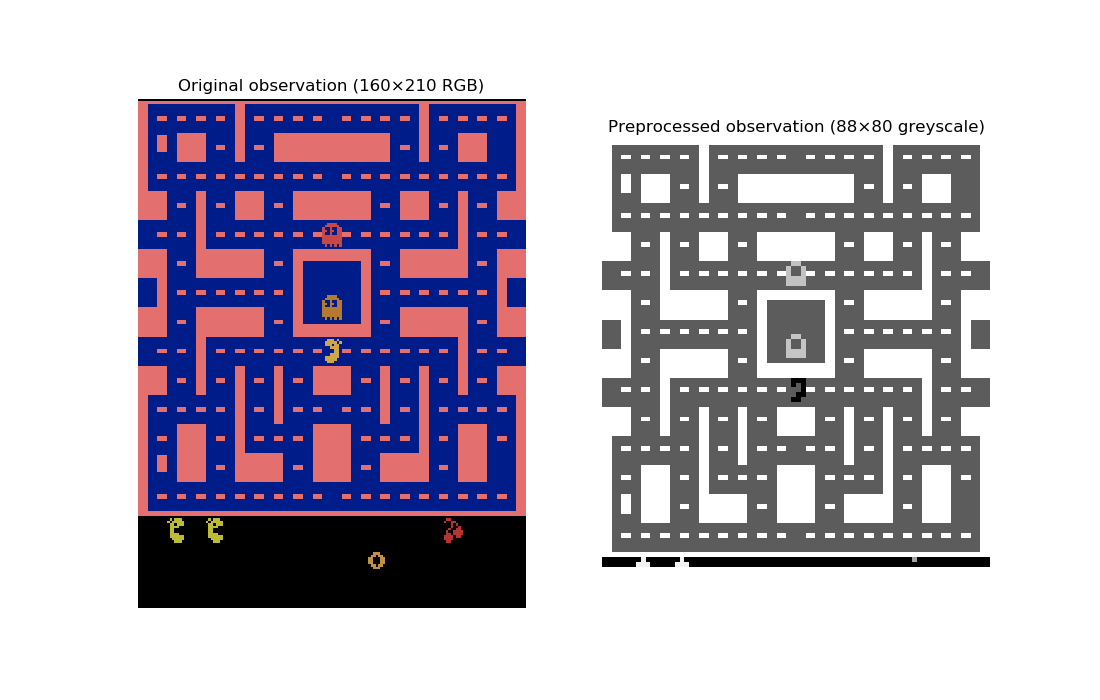

In [28]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [29]:
# build DQN, 3 convolutional layers, 2 fully connected

reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [30]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [31]:
online_vars

{'/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/dense_1/kernel:0' shape=(512, 9) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/onl

In [32]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [33]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [34]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [35]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [36]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "tmp_models/ch16_my_dqn.ckpt"
done = True # env needs to be reset

In [37]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [23]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

Iteration 225016	Training step 53754/4000000 (1.3)%	Loss 1.138691	Mean Max-Q 0.487187    

In [38]:
frames = []
n_max_steps = 20000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from tmp_models/ch16_my_dqn.ckpt


<IPython.core.display.Javascript object>


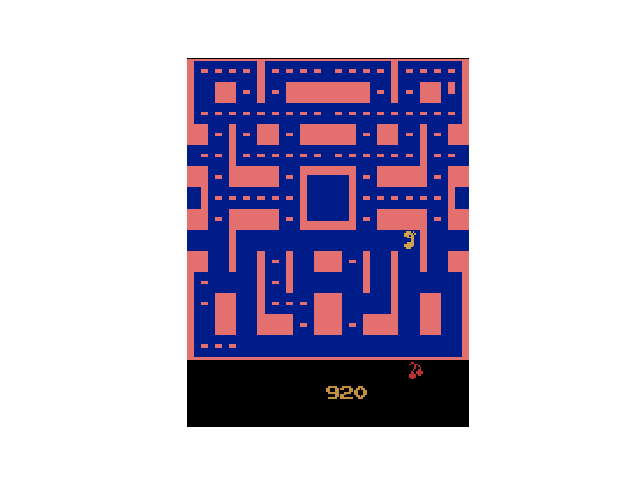

In [39]:
plot_animation(frames)